In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import json
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),   # Resize images to a fixed size
                transforms.ToTensor(),           # Convert images to PyTorch tensors
                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                     std=(0.5, 0.5, 0.5))    
            ])

# Load datasets
train_dataset = datasets.ImageFolder('imbalanced_data/train', transform=transform)
test_dataset = datasets.ImageFolder('imbalanced_data/validation', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [3]:
print(f'Numbers of Cat images: {train_dataset.targets.count(0)}')
print(f'Numbers of Dog images: {train_dataset.targets.count(1)}')

Numbers of Cat images: 1000
Numbers of Dog images: 11000


In [4]:
num_class_0 = train_dataset.targets.count(0)
num_class_1 = train_dataset.targets.count(1)
total = num_class_0 + num_class_1

weight_for_0 = total / (2.0*num_class_0)
weight_for_1 = total / (2.0*num_class_1)

class_weights = torch.FloatTensor([weight_for_0, weight_for_1]).to(device)

print('weight_for_0: ', weight_for_0)
print('weight_for_1: ', weight_for_1)

weight_for_0:  6.0
weight_for_1:  0.5454545454545454


## Model

In [5]:
from torchsummary import summary

# Load Resnet18 model
model = models.resnet18()
model.fc = nn.Linear(512, 2, bias=True)


model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Train

In [6]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4)  
max_epoch = 20

In [7]:
from sklearn.metrics import classification_report

target_names = ["Cat", "Dog"]

def cls_report(running_target, running_preds, target_names):
    targets = np.hstack(running_target[:-1])
    targets = np.concatenate((targets, running_target[-1]))
    
    predicts =  np.hstack(running_preds[:-1])
    predicts = np.concatenate((predicts, running_preds[-1]))

    report = classification_report(targets, predicts, 
                                   target_names=target_names, 
                                   zero_division=0.0, output_dict=True)
    del report['weighted avg']
    return report

In [8]:
# Function to compute loss and accuracy for test set
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_target = []
    running_pred = []
    with torch.no_grad():
        for images, targets in test_loader:
            running_target.append(targets.numpy())
            
            # Move inputs and targets to the device
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            running_pred.append(pred.cpu().numpy())
            
    test_loss = test_loss / len(test_loader)
    test_rp = cls_report(running_target, running_pred, target_names)
    return test_loss, test_rp

In [9]:
# train
hist = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
for epoch in range(max_epoch):
    running_loss = 0.0
    running_target = []
    running_pred = []
    
    model.train()
    for i, (inputs, targets) in enumerate(train_loader, 0):
        running_target.append(targets.numpy())
        
        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, pred = torch.max(outputs, 1)
        running_pred.append(pred.cpu().numpy())


    epoch_loss = running_loss / len(train_loader)
    train_rp = cls_report(running_target, running_pred, target_names)
    val_loss, val_rp = evaluate(model, test_loader, criterion)

    print(f"Epoch [{epoch + 1}/{max_epoch}]")

    print(f"Train | loss: {epoch_loss:.4f}, accuracy: {train_rp['accuracy']:.4f}")
    print(f"\tAvg | precision: {train_rp['macro avg']['precision']:.4f}, recall: {train_rp['macro avg']['recall']:.4f}, F1: {train_rp['macro avg']['f1-score']:.4f}")
    print(f"\tCat | precision: {train_rp['Cat']['precision']:.4f}, recall: {train_rp['Cat']['recall']:.4f}, F1: {train_rp['Cat']['f1-score']:.4f}")
    print(f"\tDog | precision: {train_rp['Dog']['precision']:.4f}, recall: {train_rp['Dog']['recall']:.4f}, F1: {train_rp['Dog']['f1-score']:.4f}")
    
    print(f"Valid | loss: {val_loss:.4f}, accuracy: {val_rp['accuracy']:.4f}")
    print(f"\tAvg | precision: {val_rp['macro avg']['precision']:.4f}, recall: {val_rp['macro avg']['recall']:.4f}, F1: {val_rp['macro avg']['f1-score']:.4f}")
    print(f"\tCat | precision: {val_rp['Cat']['precision']:.4f}, recall: {val_rp['Cat']['recall']:.4f}, F1: {val_rp['Cat']['f1-score']:.4f}")
    print(f"\tDog | precision: {val_rp['Dog']['precision']:.4f}, recall: {val_rp['Dog']['recall']:.4f}, F1: {val_rp['Dog']['f1-score']:.4f}")
    
    print("*"*100)

    hist["train_loss"].append(epoch_loss)
    hist["train_accuracy"].append(train_rp['accuracy'])
    hist["val_loss"].append(val_loss)
    hist["val_accuracy"].append(val_rp['accuracy'])

Epoch [1/20]
Train | loss: 0.6386, accuracy: 0.6426
	Avg | precision: 0.5432, recall: 0.6328, F1: 0.4962
	Cat | precision: 0.1371, recall: 0.6210, F1: 0.2246
	Dog | precision: 0.9493, recall: 0.6445, F1: 0.7678
Valid | loss: 0.7687, accuracy: 0.6223
	Avg | precision: 0.6808, recall: 0.6223, F1: 0.5891
	Cat | precision: 0.7836, recall: 0.3380, F1: 0.4723
	Dog | precision: 0.5780, recall: 0.9067, F1: 0.7059
****************************************************************************************************
Epoch [2/20]
Train | loss: 0.5354, accuracy: 0.7208
	Avg | precision: 0.5796, recall: 0.7259, F1: 0.5648
	Cat | precision: 0.1919, recall: 0.7320, F1: 0.3041
	Dog | precision: 0.9673, recall: 0.7198, F1: 0.8254
Valid | loss: 0.6449, accuracy: 0.6703
	Avg | precision: 0.7201, recall: 0.6703, F1: 0.6506
	Cat | precision: 0.8247, recall: 0.4327, F1: 0.5676
	Dog | precision: 0.6155, recall: 0.9080, F1: 0.7336
*********************************************************************************

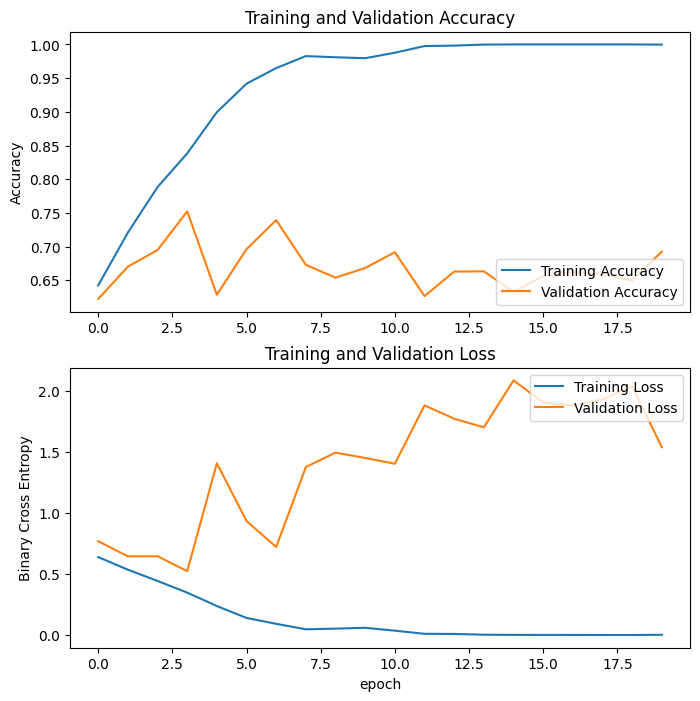

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist["train_accuracy"], label='Training Accuracy')
plt.plot(hist["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(hist["train_loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()